In [1]:
import numpy as np
from mvpa2.suite import *
import os.path as op
import sklearn
import seaborn as sns
from pywt import wavedecn
from scipy import stats
from mpl_toolkits import mplot3d
from scipy.io import loadmat
from tqdm import tqdm
from scipy.ndimage.interpolation import shift
from matplotlib.pylab import *

/Users/xueyingren/anaconda3/lib/python3.7/site-packages/mvpa2/base/hdf5.py:40: H5pyDeprecationWarning: The h5py.highlevel module is deprecated, code should import directly from h5py, e.g. 'from h5py import File'.
  import h5py.highlevel  # >= 2.8.0, https://github.com/h5py/h5py/issues/1063
/Users/xueyingren/anaconda3/lib/python3.7/site-packages/mvpa2/misc/surfing/volume_mask_dict.py:24: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Mapping


 * Please note: warnings are printed only once, but underlying problem might occur many times *


/Users/xueyingren/anaconda3/lib/python3.7/site-packages/mvpa2/testing/tools.py:82: DeprecationWarning: Importing from numpy.testing.decorators is deprecated since numpy 1.15.0, import from numpy.testing instead.
  from numpy.testing.decorators import skipif


/Users/xueyingren/anaconda3/lib/python3.7/site-packages/mvpa2/datasets/sources/skl_data.py:32: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  argnames, varargs, varkw, defaults = inspect.getargspec(fx)
<string>:57: DeprecationWarning: invalid escape sequence \c
/Users/xueyingren/anaconda3/lib/python3.7/site-packages/pywt/_utils.py:6: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Iterable


In [31]:
subj_lst = ["s1","s2","s3","s5","s6","s7","s8","s10"]

condition_face_lst = []
condition_obejcts_lst = []
condition_place_lst = []
condition_fruit_lst = []

for subject in tqdm(subj_lst):

    print(f"subject={subject}")
    
    run_lst = np.loadtxt(subject +'/'+'short_run_list.txt',dtype = str)
    
    bold_fname = []

    for i in run_lst:
        
        all_runs = (subject+'/'+subject+'.nii/'+i+'.nii')
        
        bold_fname.append(all_runs)
    
    mask = fmri_dataset(subject+'/occipital.nii') #load mask

    conditions=loadmat(subject+'/conds_short_tlrc.mat')
    conditions = conditions['conds_short_tlrc']
    conditions_sh2 = shift(conditions,[0,2], cval=0) #shift by 2 TRs
    
    def convert_binary_to_multiclass(binary_conditions):
        """Convert binary representation into multiclass reprentation:
        For example: convert [[1 1 1 1 0 0 0 0]
                              [0 0 0 0 1 1 1 1]]
        to [1 1 1 1 2 2 2 2]"""
        x,y = np.where(binary_conditions)
        conditions=np.zeros(binary_conditions.shape[1])
        conditions[y]=x+1
        return conditions

    conditions_multi = convert_binary_to_multiclass(conditions_sh2)
    
    runs = np.arange(0,512)/32
    
    ds = fmri_dataset (bold_fname, mask = subject+'/occipital.nii', targets = conditions_multi, chunks = runs)#mask = vt doesn't work here, because the error message 'array must be sequence' therefore, it has to be load with the file name
    #print ds.summary()
    
    orig_data = ds.a.mapper.reverse(ds.samples)
    orig_mask = mask.a.mapper.reverse(mask.samples)
    #orig_mask
    new_data = orig_mask * orig_data # dataset mutiply the mask ; shape(512, 64,64,42)
    #import pdb;pdb.set_trace()
    # Then I label all the conditions
    
    face = conditions_multi == 1
    objects = conditions_multi == 2
    place = conditions_multi == 3
    fruit = conditions_multi == 4
    
    face_all = new_data[face,:,:,:]
    objects_all = new_data[objects,:,:,:]
    place_all = new_data[place,:,:,:]
    fruit_all = new_data[fruit,:,:,:]
    
    face_mean = np.mean(face_all, axis = 0)
    objects_mean = np.mean(objects_all, axis = 0)
    place_mean = np.mean(place_all,axis = 0)
    fruit_mean =  np.mean(fruit_all, axis = 0)
    
    condition_max = np.argmax([face_mean, objects_mean, place_mean, fruit_mean],axis = 0)
    
    condition_face = (condition_max == 0)*orig_mask[0] # condition_max ==0 (the first element):face_mean; also includes the voxels values equal zero.  
    condition_objects = (condition_max == 1) # no need to mutiply mask 
    condition_place = (condition_max == 2)
    condition_fruit = (condition_max == 3)
    
    condition_face_lst.append(condition_face) # it is a mask tells you which voxels have maximum activation of faces
    condition_obejcts_lst.append(condition_objects)#it is a mask tells you which voxels have maximum activation of objects
    condition_place_lst.append(condition_place)
    condition_fruit_lst.append(condition_fruit)
    
    new_mask = orig_mask.copy()[0]
    #import pdb;pdb.set_trace()
    new_mask [condition_face.astype(bool)] = 1
    new_mask [condition_objects.astype(bool)] = 2
    new_mask [condition_place.astype(bool)] = 3
    new_mask [condition_fruit.astype(bool)] = 4
    
    fm = mask.a.mapper
    mask.samples = fm.forward(new_mask.reshape(1,64,64,42))
    map2nifti(mask).to_filename(f"{subject}_condition_map.nii")
    #import pdb;pdb.set_trace()









  0%|          | 0/8 [00:00<?, ?it/s]

subject=s1










 12%|█▎        | 1/8 [00:06<00:46,  6.58s/it]

subject=s2










 25%|██▌       | 2/8 [00:13<00:40,  6.71s/it]

subject=s3










 38%|███▊      | 3/8 [00:18<00:31,  6.23s/it]

subject=s5










 50%|█████     | 4/8 [00:23<00:23,  5.82s/it]

subject=s6










 62%|██████▎   | 5/8 [00:28<00:16,  5.52s/it]

subject=s7










 75%|███████▌  | 6/8 [00:34<00:11,  5.65s/it]

subject=s8










 88%|████████▊ | 7/8 [00:39<00:05,  5.52s/it]

subject=s10










100%|██████████| 8/8 [00:44<00:00,  5.55s/it]


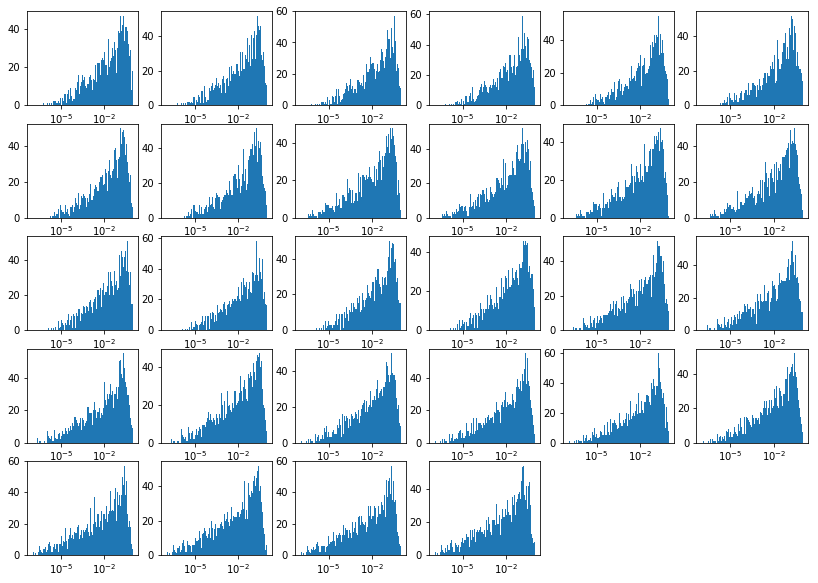

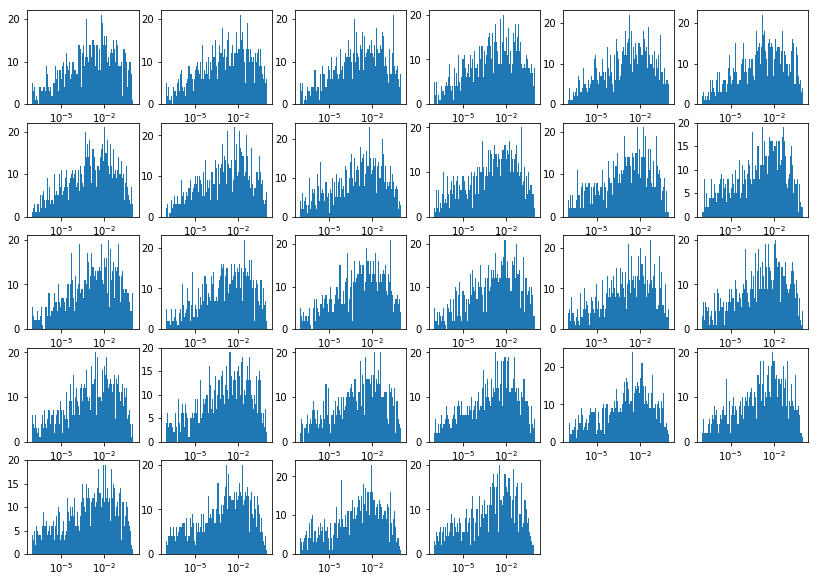

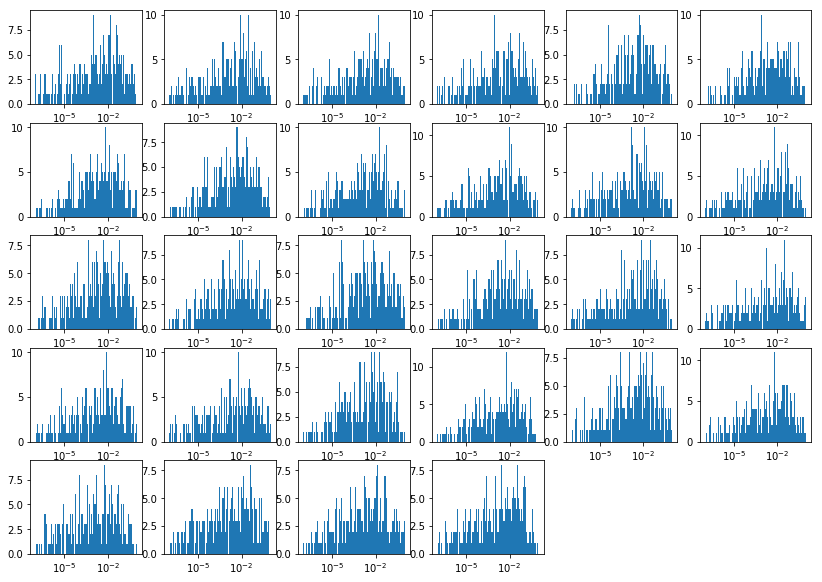

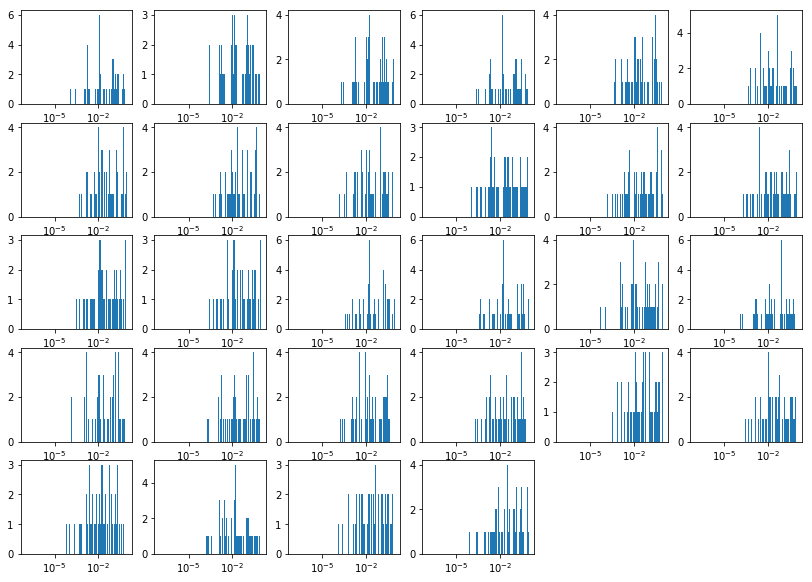

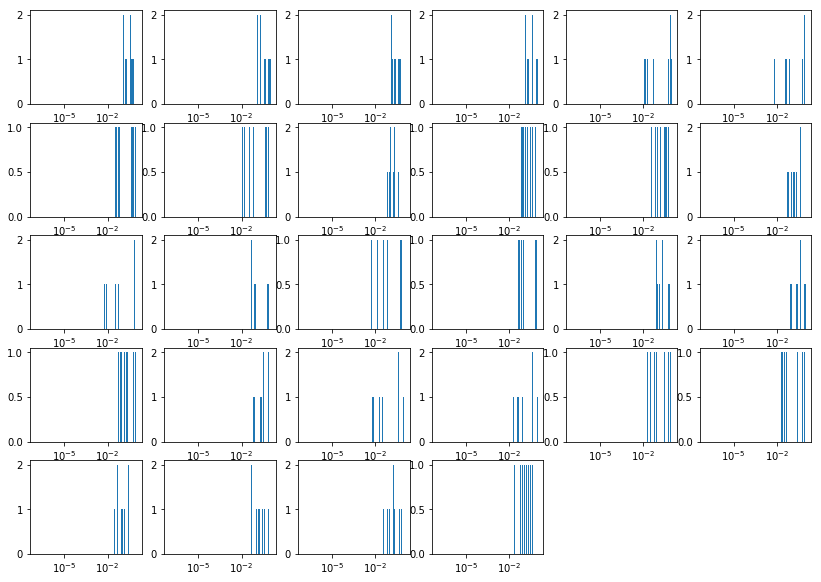

In [3]:
# plot the coefficients for each scale. #animal 8
for i in range(5):
    plt.figure(figsize = (14,10))
    for j in range(28):
        plt.subplot(5,6,j+1)
        a = wvt.highpasses[i][:,:,:,j]
        a = abs(a[a != 0])
        #b = a.ravel()
        plt.hist(a, bins = np.logspace(-7,0,100));
        #plt.yscale('log')
        plt.xscale('log')